In [11]:
import torch
import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


## Conditional Generative Adversarial Network for Spike Detection ##

This notebook is part of an ongoing project that contributes to my PhD dissertation. The objective is to train a Generative Adversarial Network (GAN) capable of generating current traces that closely resemble real experimental data.

Single-molecule (SM) data often presents two extremes: Big Data and Small Data. In the context of SM experiments, big data refers to complexity, high dimensionality, significant noise, and multi-source variability. Consider, for example, Figure 1, which shows a relatively clean trace collected from nanoparticles passing through a nanopore. Each spike corresponds to a change in voltage, recorded as current over time. While the trace may appear simple, it encodes rich information about the underlying physics—such as the conformation of the molecule or the number of molecules translocating the pore. However, due to limitations in both instrumentation and analysis techniques, much of this information is lost. A plateau in the signal, for instance, could indicate either random fluctuations or a meaningful physical event. Figure 2 illustrates a more realistic scenario—data that includes both noise and structural complexity—highlighting the challenges faced when interpreting SM traces. Machine Learning (ML) offers new tools to analyze such data at scale, enabling higher accuracy and better recall than traditional approaches.

At the other extreme is small data, which is equally common in this subfield of nanoscience. It's not unusual for a researcher to spend 12 hours in the lab collecting gigabytes of data, only to find that most of it is unusable. As a rule of thumb, only about 30% of the data ends up being useful for analysis. This limitation persists even with the most advanced instruments—after all, we are working at the single-molecule level. Machine learning also provides promising solutions here. Using GANs and Variational Autoencoders (VAEs), we can impute missing data and generate synthetic traces that support meaningful analysis, even when usable data is limited.

In [15]:
file_1 = "2_3 electroporation-005_Cut_1.h5"
file_2 = "WangsData/4_detection 100 pM nisin with fibrin -014_Cut_1.h5"



In [5]:
def load_data(filepath, key='current'):
    with h5py.File(filepath, 'r') as f:
        trace = f[key][:]
    return trace.astype(np.float32)

def extract_zoomed_spike_segments(trace, window_size=64, threshold=0.05):
    baseline = 0.01
    spike_idxs = np.where(np.abs(trace - baseline) > threshold)[0]
    half_w = window_size // 2

    segments = []
    for idx in spike_idxs:
        if idx > half_w and idx + half_w < len(trace):
            segment = trace[idx - half_w:idx + half_w]
            segments.append(segment)

    segments = np.array(segments)
    segments = ((segments - baseline) / 0.27).astype(np.float32)
    return segments[..., np.newaxis]


def extract_base_segments(trace, window_size=200, threshold=0.05, baseline=0.01):
    num_segments = len(trace) // window_size
    segments = trace[:num_segments*window_size].reshape(-1, window_size)
    labels = (np.max(np.abs(segments - baseline), axis=1) > threshold).astype(int)
    base = segments[labels == 0]
    return base[..., np.newaxis]
def spike_amplifier_loss(waveforms, target_amp=0.25):
    peak = torch.max(torch.abs(waveforms[:, :, 0]), dim=1)[0]
    return -torch.mean(peak - target_amp)
def generator_loss(fake_pred, fake_waveforms, real_waveforms, sharp_weight=10, l1_weight=10, fft_weight=2, amp_weight=5):
    adv = nn.BCELoss()(fake_pred, torch.ones_like(fake_pred))
    l1 = nn.L1Loss()(fake_waveforms, real_waveforms)
    fft = fft_loss(real_waveforms, fake_waveforms)
    sharp = spike_sharpness_loss(fake_waveforms)
    amp = spike_amplifier_loss(fake_waveforms)

    return adv + l1_weight * l1 + fft_weight * fft + sharp_weight * sharp + amp_weight * amp, adv, l1, fft, sharp, amp




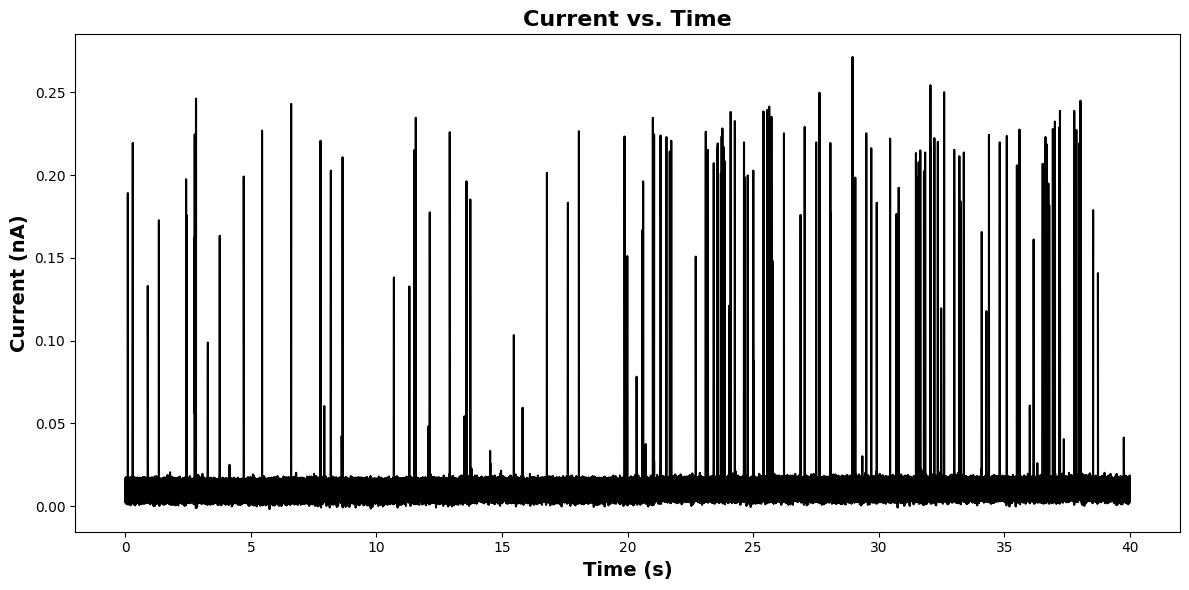

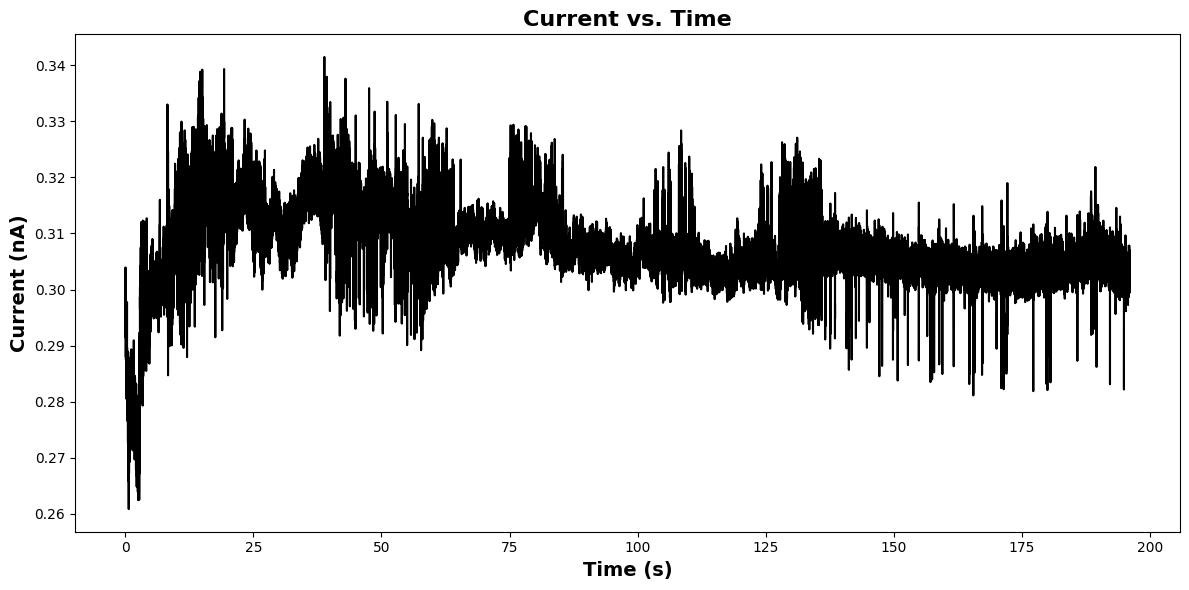

In [29]:
c1 = load_data(file_1)
c2 = load_data(file_2)
sr = 50000 # Sampling Rate
timevector1 = np.arange(0,len(c1))/sr
timevector2 = np.arange(0,len(c2))/sr

# Figure 1. Simple Data Set

plt.figure(figsize=(12,6))
plt.plot(timevector1,c1,color='black')
plt.xlabel("Time (s)",fontweight='bold',fontsize=14)
plt.ylabel("Current (nA)",fontweight='bold',fontsize=14)
plt.title("Current vs. Time",fontweight='bold',fontsize=16)
plt.tight_layout()
plt.show()

# Figure 2. Complex Data
plt.figure(figsize=(12,6))
plt.plot(timevector2,c2,color='black')
plt.xlabel("Time (s)",fontweight='bold',fontsize=14)
plt.ylabel("Current (nA)",fontweight='bold',fontsize=14)
plt.title("Current vs. Time",fontweight='bold',fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
class LabeledSpikeDataset(Dataset):
    def __init__(self, spike_segments, base_segments):
        self.data = torch.cat([
            torch.from_numpy(spike_segments).float(),
            torch.from_numpy(base_segments).float()
        ])
        self.labels = torch.cat([
            torch.ones(len(spike_segments), 1),
            torch.zeros(len(base_segments), 1)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        label = self.labels[idx]
        return x, x, label  # real, condition, label


In [124]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, seq_len=64):
        super().__init__()
        self.seq_len = seq_len
        self.latent_to_seq = nn.Sequential(
            nn.Linear(latent_dim, seq_len * 32),
            nn.LeakyReLU(0.2),
        )
        self.lstm = nn.Sequential(
            nn.LSTM(34, 256, batch_first=True),
            nn.LSTM(256, 128, batch_first=True),
            nn.LSTM(128, 64, batch_first=True),
        )
        self.output_layer = nn.Sequential(
            nn.Linear(64 + 34, 1),
            nn.Tanh()
        )

    def forward(self, z, condition_trace, spike_label):
        B, T = z.size(0), self.seq_len
        x = self.latent_to_seq(z).view(B, T, 32)
        spike_label_repeated = spike_label.view(B, 1, 1).expand(-1, T, 1)
        x_in = torch.cat([x, condition_trace, spike_label_repeated], dim=2)
        skip = x_in
        lstm_out, _ = self.lstm[0](x_in)
        lstm_out, _ = self.lstm[1](lstm_out)
        lstm_out, _ = self.lstm[2](lstm_out)
        out = torch.cat([lstm_out, skip], dim=2)
        return self.output_layer(out)


class SpikeDiscriminator(nn.Module):
    def __init__(self, seq_len=64):
        super().__init__()
        self.seq_len = seq_len
        self.model = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
        )
        self.rnn = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, trace, condition_trace, spike_label):
        B, T = trace.size(0), self.seq_len
        label_repeated = spike_label.view(B, 1, 1).expand(-1, T, 1)
        x = torch.cat([trace, condition_trace, label_repeated], dim=2)
        x = x.permute(0, 2, 1)
        conv_out = self.model(x)
        conv_out = conv_out.permute(0, 2, 1)
        rnn_out, _ = self.rnn(conv_out)
        return self.fc(rnn_out[:, -1, :])


In [152]:
def spike_amplifier_loss(waveforms, target_amp=0.25):
    peak = torch.max(torch.abs(waveforms[:, :, 0]), dim=1)[0]
    return -torch.mean(peak - target_amp)

def fft_loss(real, fake):
    real_fft = torch.fft.fft(real.squeeze(-1), dim=1)
    fake_fft = torch.fft.fft(fake.squeeze(-1), dim=1)
    return torch.mean(torch.abs(torch.abs(real_fft) - torch.abs(fake_fft)))

def spike_sharpness_loss(signal, threshold=0.2):
    diff = torch.abs(signal[:, 1:, 0] - signal[:, :-1, 0])
    return -torch.mean((diff > threshold).float())

def generator_loss(fake_pred, fake, real, sharp_weight=60, l1_weight=60, fft_weight=20, amp_weight=20):
    adv = nn.BCELoss()(fake_pred, torch.ones_like(fake_pred))
    l1 = nn.L1Loss()(fake, real)
    fft = fft_loss(real, fake)
    sharp = spike_sharpness_loss(fake)
    amp = spike_amplifier_loss(fake)
    return adv + l1_weight * l1 + fft_weight * fft + sharp_weight * sharp + amp_weight * amp, adv, l1, fft, sharp, amp


In [126]:
from torch.utils.data import TensorDataset, DataLoader

def prepare_spike_loader(trace, window_size=64, batch_size=64):
    spike_segments = extract_zoomed_spike_segments(trace, window_size)
    dataset = TensorDataset(torch.tensor(spike_segments))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


In [34]:
def train_gan(
    generator, discriminator, dataloader,
    latent_dim=100, num_epochs=200, device='mps',
    print_every=25, show_plots=True
):
    generator.to(device)
    discriminator.to(device)
    opt_g = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    d_losses, g_losses, g_l1s, g_ffts = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        for real, condition, spike_label in dataloader:
            real, condition, spike_label = real.to(device), condition.to(device), spike_label.to(device)
            B = real.size(0)
            z = torch.randn(B, latent_dim, device=device)

            real_labels = torch.ones(B, 1, device=device)
            fake_labels = torch.zeros(B, 1, device=device)

            # Discriminator
            fake = generator(z, condition, spike_label)
            real_out = discriminator(real, condition, spike_label)
            fake_out = discriminator(fake.detach(), condition, spike_label)

            d_loss = nn.BCELoss()(real_out, real_labels * 0.9) + nn.BCELoss()(fake_out, fake_labels)
            opt_d.zero_grad(); d_loss.backward(); opt_d.step()

            # Generator
            z = torch.randn(B, latent_dim, device=device)
            fake = generator(z, condition, spike_label)
            pred = discriminator(fake, condition, spike_label)

            adv = nn.BCELoss()(pred, real_labels)
            l1 = nn.L1Loss()(fake, real)
            fft = torch.mean(torch.abs(
                torch.fft.fft(real.squeeze(-1), dim=1) -
                torch.fft.fft(fake.squeeze(-1), dim=1)
            ))
            g_loss = adv + 20 * l1 + 10 * fft

            opt_g.zero_grad(); g_loss.backward(); opt_g.step()

        # Logging and tracking
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        g_l1s.append(l1.item())
        g_ffts.append(fft.item())

        if epoch % print_every == 0:
            print(f"[{epoch:03}] D: {d_loss.item():.4f} | G: {g_loss.item():.4f} "
                  f"(adv: {adv.item():.4f}, L1: {l1.item():.4f}, FFT: {fft.item():.4f})")

            if show_plots:
                generator.eval()
                with torch.no_grad():
                    z = torch.randn(4, latent_dim, device=device)
                    labels = torch.tensor([[0.], [1.], [1.], [0.]], device=device)
                    cond = condition[:4]

                    gen = generator(z, cond, labels).cpu().numpy().squeeze()
                    cond_np = cond.cpu().numpy().squeeze()

                    fig, axs = plt.subplots(4, 1, figsize=(10, 8))
                    fig.suptitle(f"Generated Output — Epoch {epoch}", fontsize=14)
                    for i in range(4):
                        axs[i].plot(cond_np[i], label='Condition', color='gray', alpha=0.5)
                        axs[i].plot(gen[i], label='Generated', color='darkorange')
                        axs[i].legend(loc='upper right', fontsize=8)
                        axs[i].set_xticks([]); axs[i].set_yticks([])

                    plt.tight_layout(); plt.show()
                generator.train()

    return d_losses, g_losses, g_l1s, g_ffts


[025] D: 1.3775 | G: 1.9632 (adv: 0.7720, L1: 0.0053, FFT: 0.1084)


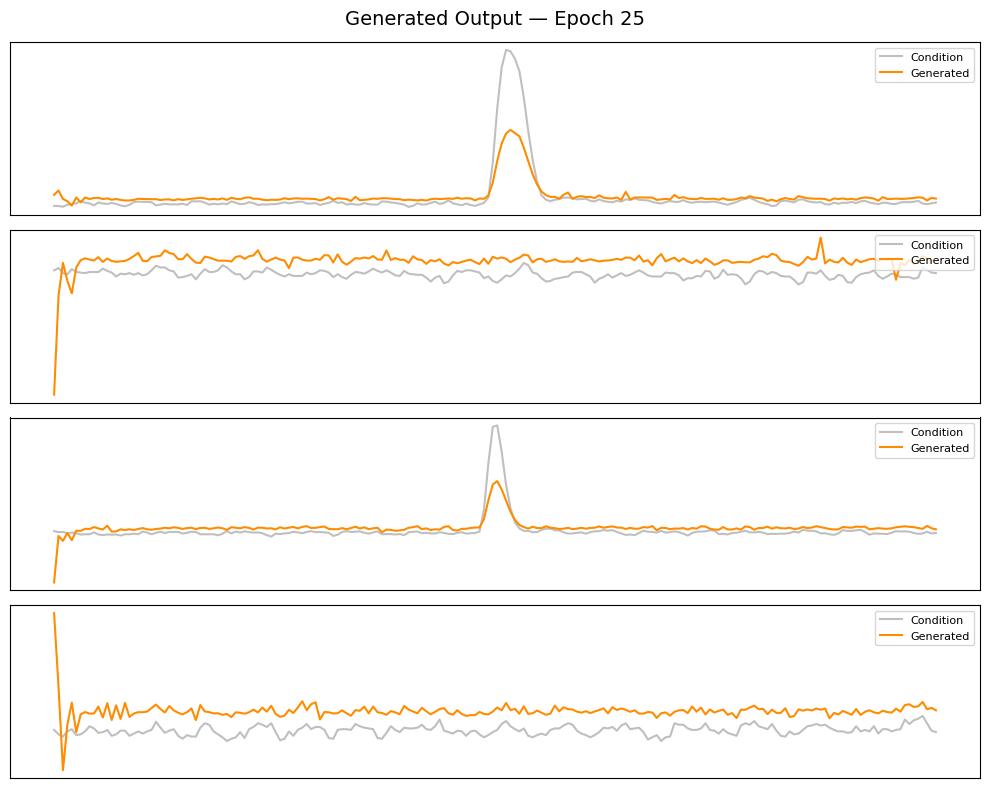

[050] D: 1.3784 | G: 1.4140 (adv: 0.7844, L1: 0.0056, FFT: 0.0517)


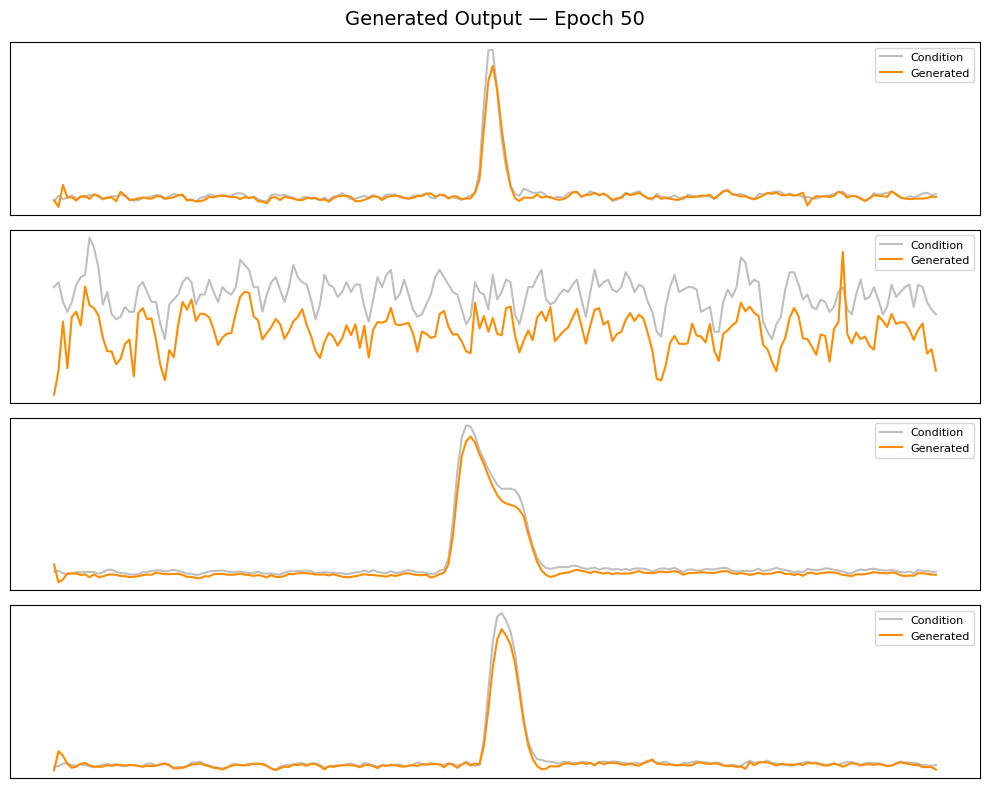

[075] D: 1.3760 | G: 1.0956 (adv: 0.7912, L1: 0.0047, FFT: 0.0210)


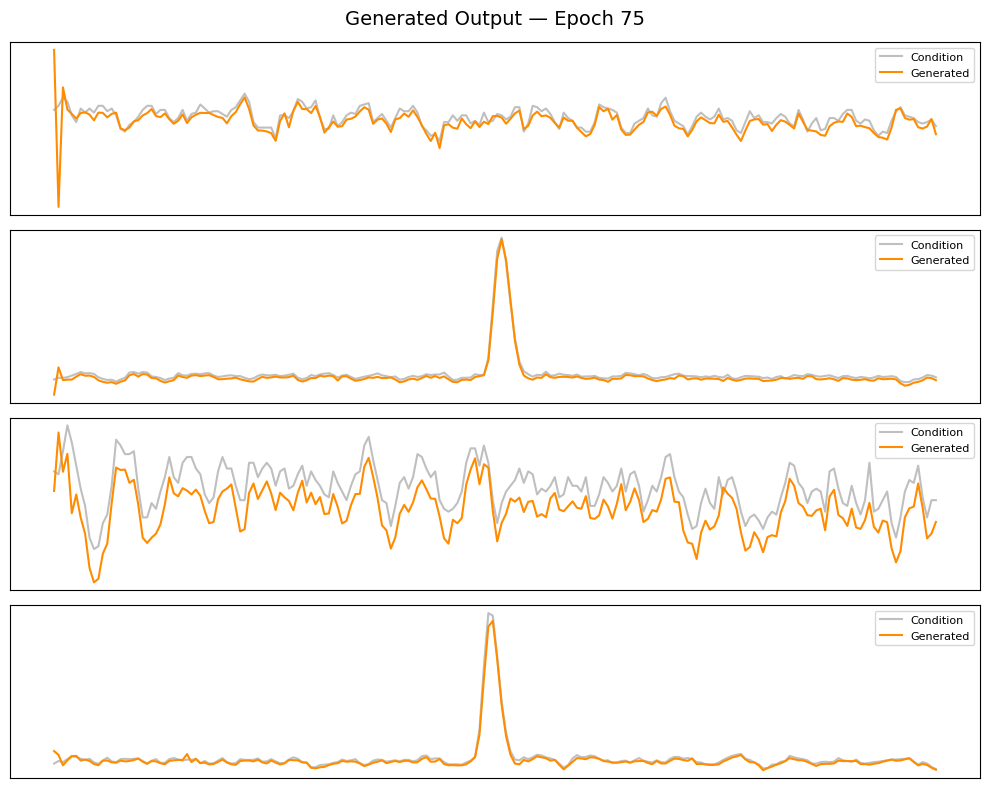

[100] D: 1.3751 | G: 0.9712 (adv: 0.8018, L1: 0.0025, FFT: 0.0119)


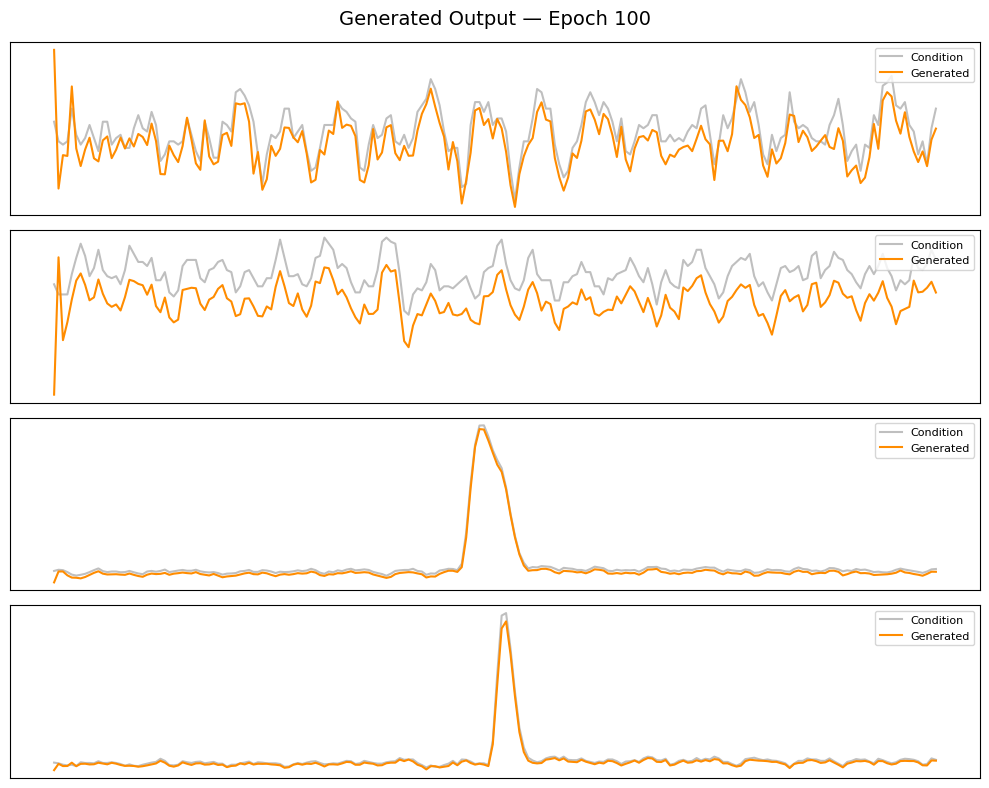

[125] D: 1.3751 | G: 0.9060 (adv: 0.8016, L1: 0.0012, FFT: 0.0081)


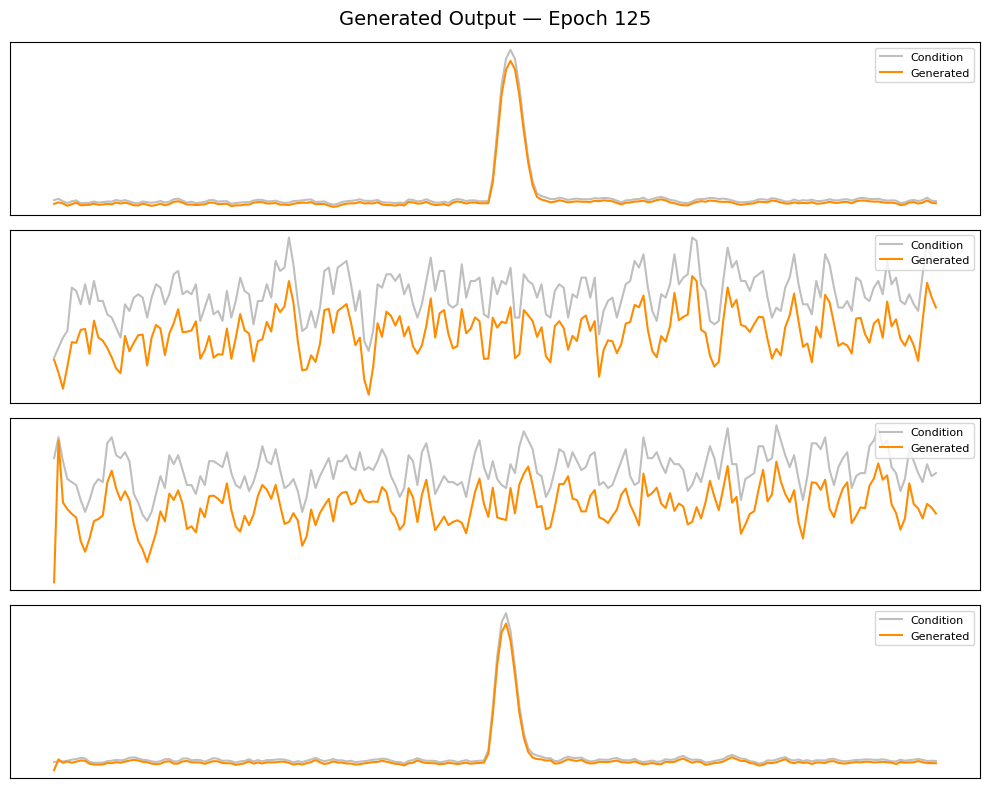

[150] D: 1.3703 | G: 0.9412 (adv: 0.8100, L1: 0.0024, FFT: 0.0082)


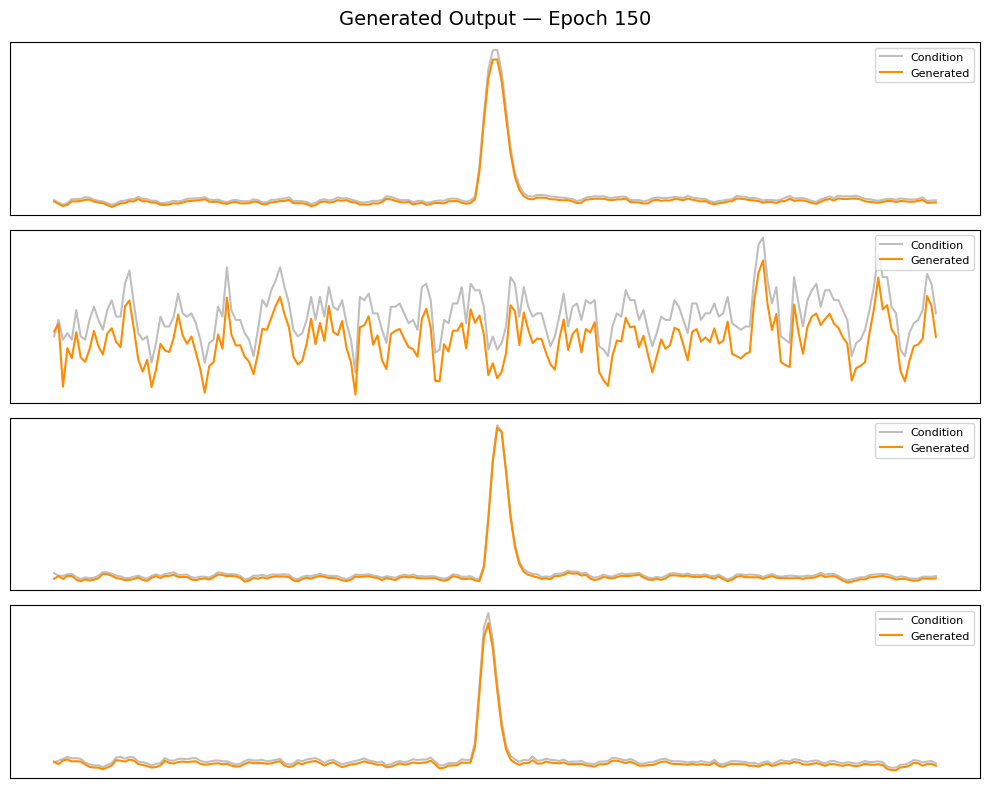

[175] D: 1.3784 | G: 0.9839 (adv: 0.8488, L1: 0.0029, FFT: 0.0076)


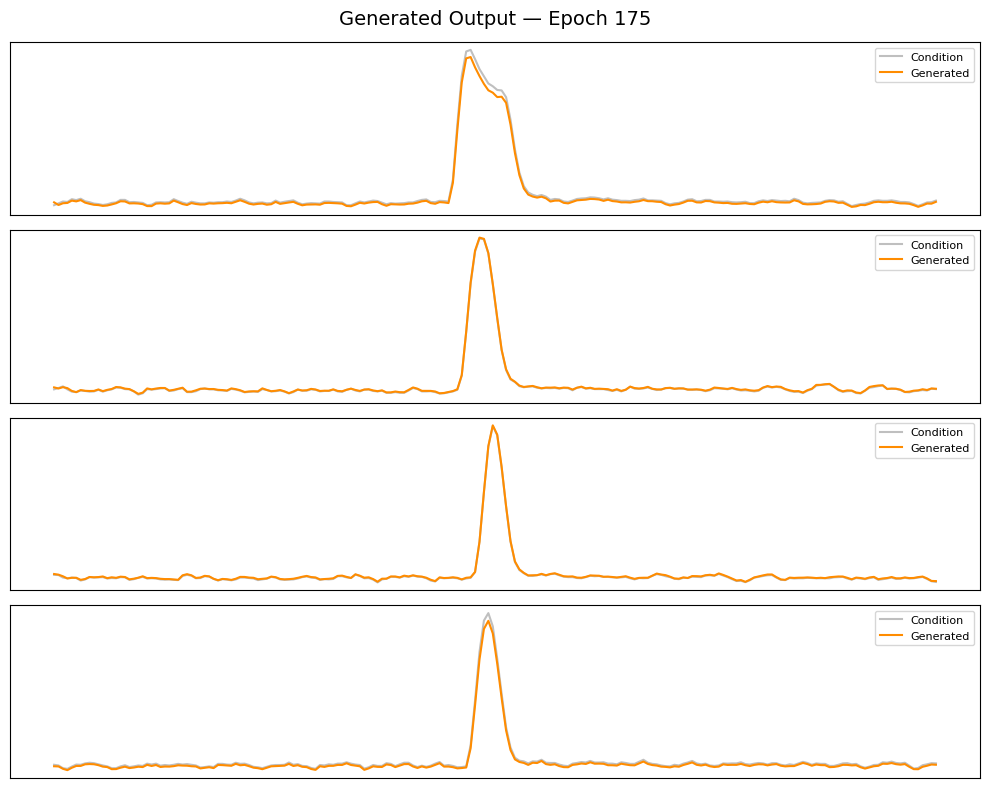

[200] D: 1.3764 | G: 0.8469 (adv: 0.7720, L1: 0.0014, FFT: 0.0048)


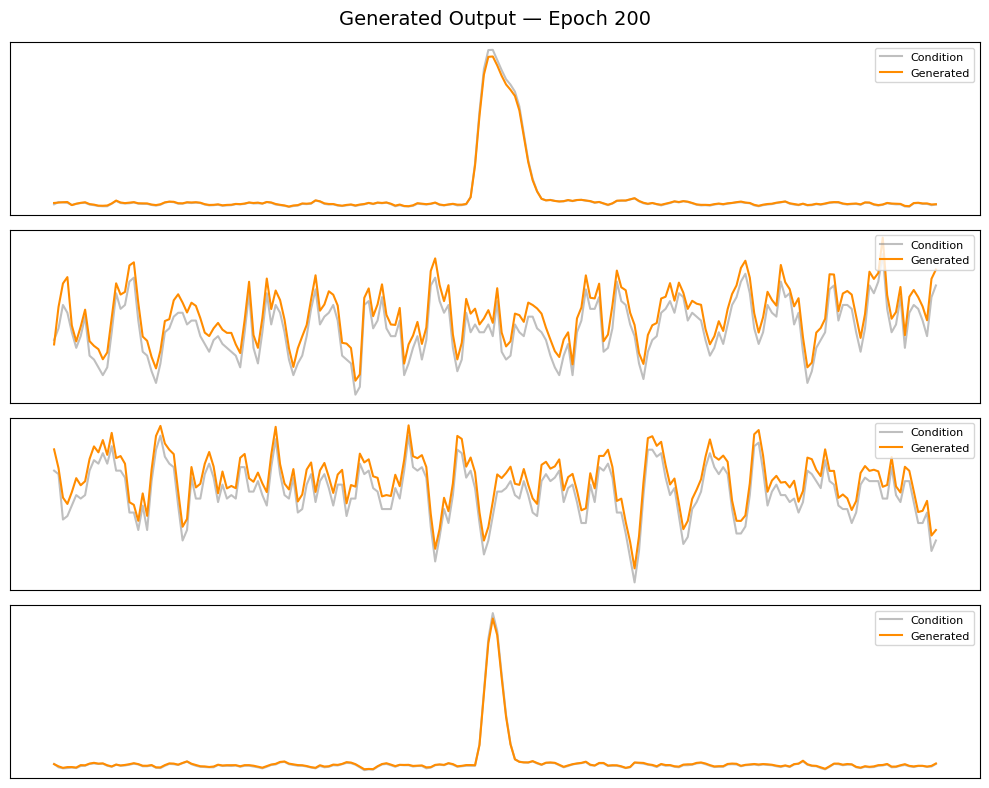

[225] D: 1.3759 | G: 0.8676 (adv: 0.8061, L1: 0.0013, FFT: 0.0036)


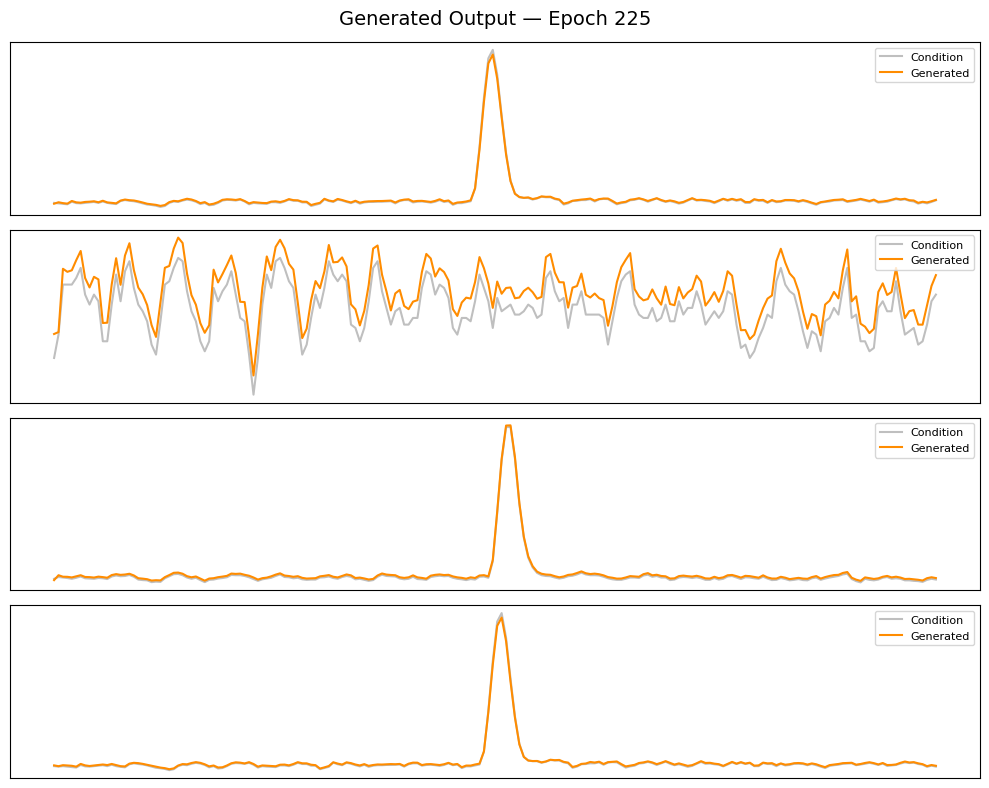

[250] D: 1.3721 | G: 0.8441 (adv: 0.7818, L1: 0.0014, FFT: 0.0035)


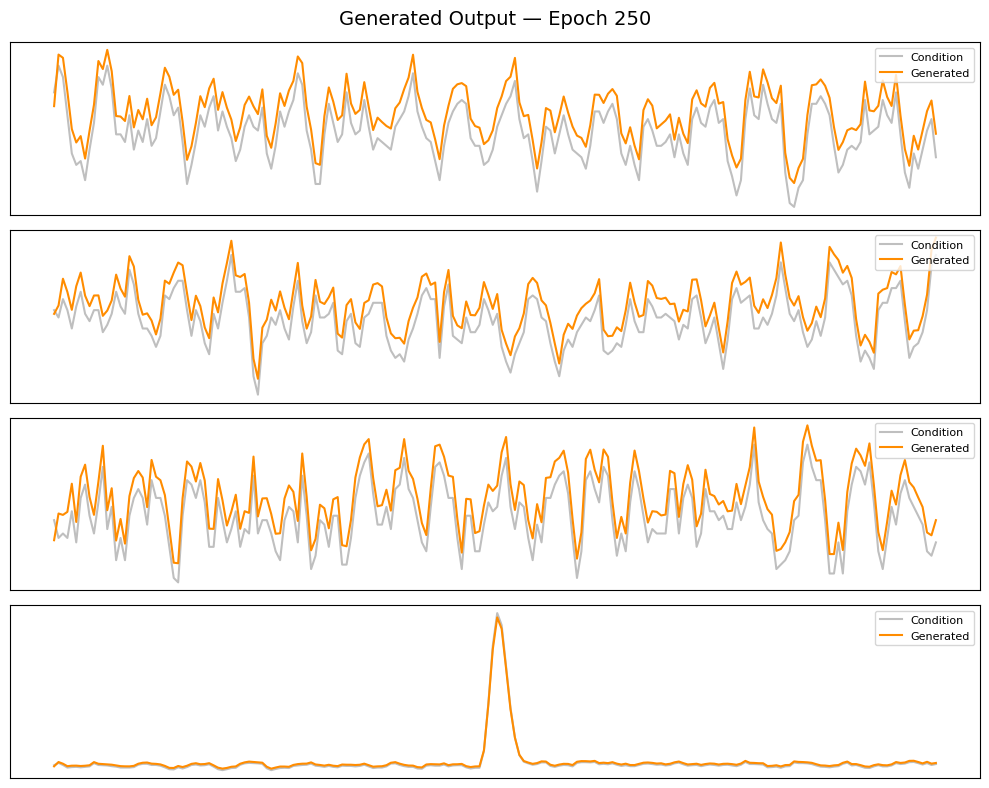

[275] D: 1.3730 | G: 0.9061 (adv: 0.8524, L1: 0.0011, FFT: 0.0032)


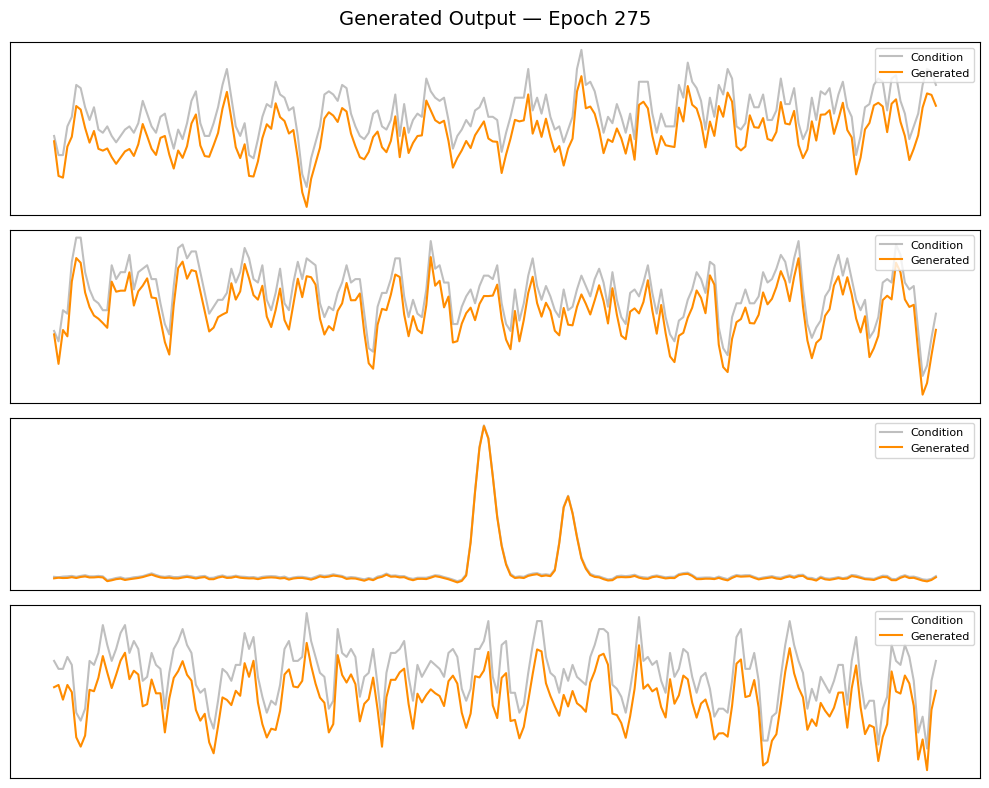

[300] D: 1.3757 | G: 0.8356 (adv: 0.7898, L1: 0.0010, FFT: 0.0027)


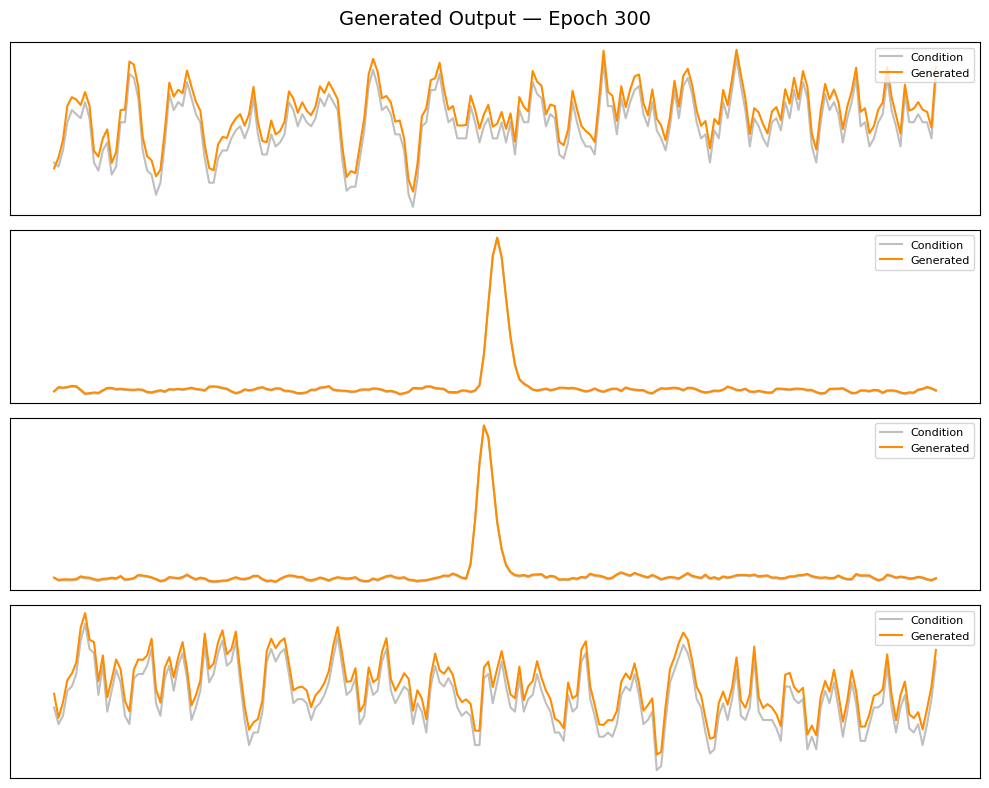

([1.3753911256790161,
  1.3461644649505615,
  1.0607832670211792,
  1.3108681440353394,
  1.2976164817810059,
  1.381259560585022,
  1.3361742496490479,
  1.3956220149993896,
  1.3902125358581543,
  1.3846800327301025,
  1.359529972076416,
  1.2517586946487427,
  1.38433837890625,
  1.367034912109375,
  1.3672877550125122,
  1.35274338722229,
  1.3875011205673218,
  1.3794456720352173,
  1.3798046112060547,
  1.381274700164795,
  1.3784066438674927,
  1.3757753372192383,
  1.3773677349090576,
  1.377065658569336,
  1.3774921894073486,
  1.3752162456512451,
  1.3762569427490234,
  1.3728511333465576,
  1.3764023780822754,
  1.3745465278625488,
  1.3759583234786987,
  1.375081181526184,
  1.3756392002105713,
  1.3700664043426514,
  1.376723051071167,
  1.3707358837127686,
  1.374664306640625,
  1.376180648803711,
  1.3473018407821655,
  1.3782930374145508,
  1.3739511966705322,
  1.376158356666565,
  1.3831751346588135,
  1.37818443775177,
  1.3738298416137695,
  1.3781583309173584,
  1.

In [36]:
file_path = "2_3 electroporation-005_Cut_1.h5"
raw_trace = load_data(file_path)

spike_segments = extract_zoomed_spike_segments(raw_trace, window_size=200)
base_segments = extract_base_segments(raw_trace, window_size=200, threshold=0.05)
base_segments = base_segments[:len(spike_segments)]

dataset = LabeledSpikeDataset(spike_segments, base_segments)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

G = ConditionalSpikeGenerator()
D = SpikeDiscriminator()

train_gan(G, D, loader, num_epochs=300)


In [42]:
torch.save(G.state_dict(), "spike_generator_final.pth")


In [44]:
total_length = 2_000_000          # total number of points
segment_len = 200                 # segment length from training
stride = 100                      # overlap stride
num_spikes = 300                  # number of spike windows to inject
latent_dim = 100


In [46]:
def generate_base_trace(generator, total_length, segment_len=200, stride=100, device='mps'):
    generator.eval()
    segments = []
    with torch.no_grad():
        for _ in range(0, total_length - segment_len, stride):
            z = torch.randn(1, latent_dim, device=device)
            condition = torch.zeros(1, segment_len, 1, device=device)
            label = torch.zeros(1, 1, device=device)
            seg = generator(z, condition, label).cpu().squeeze().numpy()
            segments.append(seg)

    # Overlap-add with averaging
    trace = np.zeros(total_length)
    counts = np.zeros(total_length)

    for i, seg in enumerate(segments):
        start = i * stride
        trace[start:start + segment_len] += seg
        counts[start:start + segment_len] += 1

    counts[counts == 0] = 1
    return trace / counts


In [48]:
def inject_spikes(base_trace, generator, num_spikes=300, segment_len=200, device='mps'):
    modified = base_trace.copy()
    total_length = len(modified)
    insertion_points = np.random.choice(range(segment_len, total_length - segment_len), size=num_spikes, replace=False)

    for idx in insertion_points:
        z = torch.randn(1, latent_dim, device=device)
        condition = torch.zeros(1, segment_len, 1, device=device)
        label = torch.ones(1, 1, device=device)

        with torch.no_grad():
            spike = generator(z, condition, label).cpu().squeeze().numpy()

        # Inject using smooth window
        w = np.hanning(segment_len)
        injected = spike * w + modified[idx - segment_len//2:idx + segment_len//2] * (1 - w)
        modified[idx - segment_len//2:idx + segment_len//2] = injected

    return modified, insertion_points


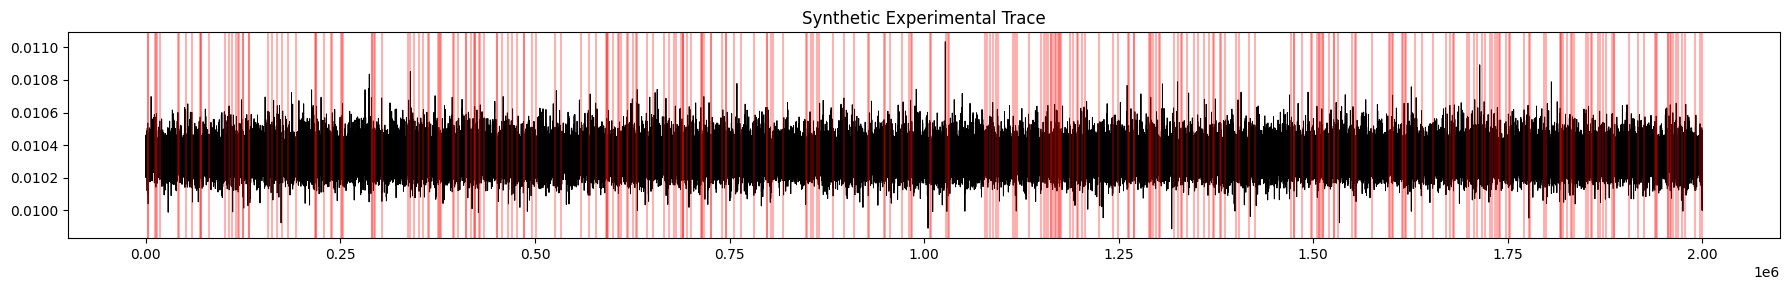

In [54]:
base_trace = generate_base_trace(G, total_length, device='mps')
full_trace, spike_indices = inject_spikes(base_trace, G, device='mps')

plt.figure(figsize=(18, 3))
plt.plot(full_trace * 0.27 + 0.01, color='black', lw=0.7)
plt.title("Synthetic Experimental Trace")
for s in spike_indices:
    plt.axvline(s, color='red', alpha=0.3)
plt.tight_layout()
plt.show()
